# Evaluating classification algorithms on simulated single tracks

This notebook uses the classifier trained via "inspect_single_tracks.ipynb" and evaluates their performance. Execute each cell one after the other. Many functions, like setting up the neural networks or calucalting the confusion matrix are defined in: "analysis_utils.py".

## Load libraries and settings

In [12]:
import numpy as np
import pandas as pd
from analysis_utils import analysis_utils
from joblib import load
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf

ana_utils = analysis_utils()

#MAKE CHANGES HERE
#*******************************************************************
charge = -1 #Choose -1 / 1 (negative / positive) for selecting a specific particle charge
ana_add_name = 'demo' #--> Change this to customize the name of the produced plots and trained networks
#(However, it should be consistent with the name you used in 'inspect_single_tracks.py')
n_df_rows = 0 #Change this to a number > 0, if you want to print out the first n_df_rows rows of the dataframe
#*******************************************************************

## Load data frame

In [13]:
dataDir = 'http://hadron.physics.fsu.edu/~dlersch/Intro_To_ML_2021/data/'
particle_dict = {
    -1: ['Neg_LepPi_DF_small','Electrons','Negative Pions'], #--> You may remove the '_small' and anlyze the full data set discussed in the lecture 
     1: ['Pos_LegPi_DF_small','Positrons','Positive Pions']  #however, the analysis might take significantly longer 
}

plot_dict = {
    -1: ['electrons','neg_pions','neg_particles'],
    1: ['positrons','pos_pions','pos_particles'],
}

data_df = pd.read_csv(dataDir + particle_dict[charge][0] + '.csv')
features = ['p','theta','ddEdx_CDC','dE_BCAL','ddEdx_FDC','dE_FCAL']

## Load trained neural networks

In [14]:
scikit_mlp_classifier = load('scikit_mlp_' + plot_dict[charge][2] + '_' + ana_add_name + '.joblib')
keras_mlp_classifier = tf.keras.models.load_model('keras_mlp_' + plot_dict[charge][2] + '_' + ana_add_name + '.h5')

## Add model predictions to the data frame

In [15]:
X = data_df[features]
Y = data_df['label']

scikit_probabilities = scikit_mlp_classifier.predict_proba(X)
scikit_labels = scikit_mlp_classifier.predict(X) #--> The labels (0,1) are obtained for a threshold that has been optimized internally

keras_probabilities = keras_mlp_classifier.predict(X)
#--> Will deal later with the threshold value

data_df['scikit_prob_lep'] = scikit_probabilities[:,1] #--> mlp_probabilities[:,0] would yield the output distribution for pion tracks
data_df['scikit_label'] = scikit_labels

data_df['keras_prob_lep'] = keras_probabilities

## Get model responses

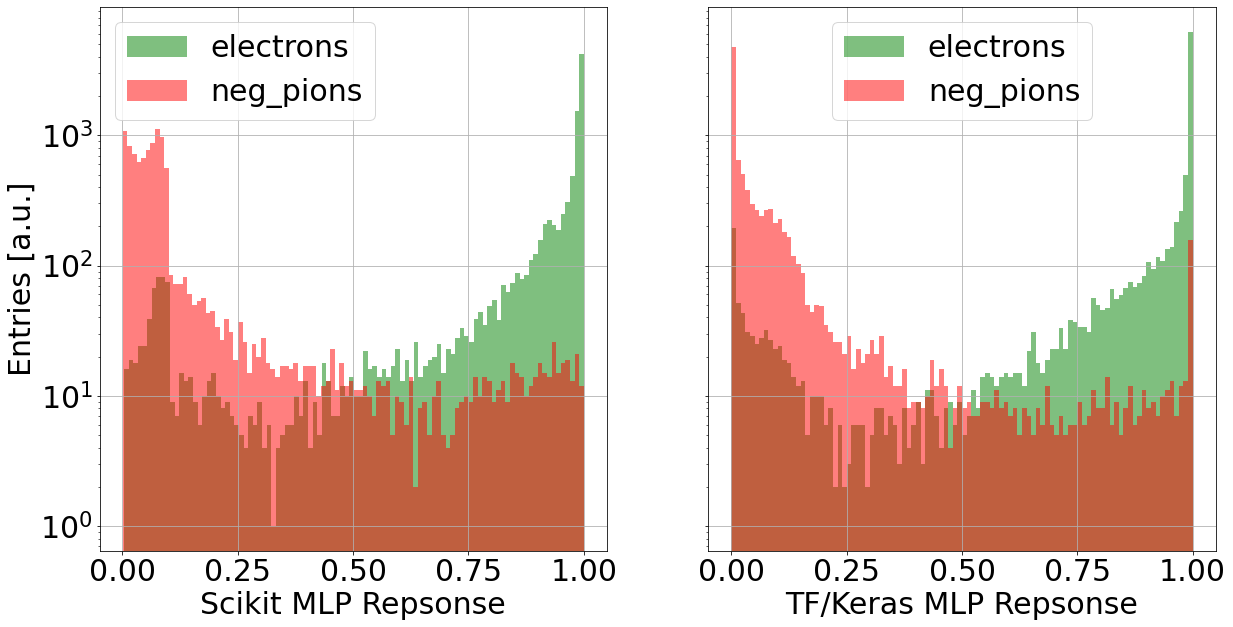

In [16]:
plt.rcParams.update({'font.size': 30})
fig_out,ax_out = plt.subplots(1,2,sharey=True,figsize=(20,10))

ax_out[0].hist(data_df[data_df['label']==1.0]['scikit_prob_lep'],100,alpha=0.5,facecolor='g',label=plot_dict[charge][0],log=True)
ax_out[0].hist(data_df[data_df['label']==0.0]['scikit_prob_lep'],100,alpha=0.5,facecolor='r',label=plot_dict[charge][1],log=True)

ax_out[0].set_xlabel('Scikit MLP Repsonse')
ax_out[0].set_ylabel('Entries [a.u.]')
ax_out[0].legend()
ax_out[0].grid(True)

ax_out[1].hist(data_df[data_df['label']==1.0]['keras_prob_lep'],100,alpha=0.5,facecolor='g',label=plot_dict[charge][0],log=True)
ax_out[1].hist(data_df[data_df['label']==0.0]['keras_prob_lep'],100,alpha=0.5,facecolor='r',label=plot_dict[charge][1],log=True)

ax_out[1].set_xlabel('TF/Keras MLP Repsonse')
ax_out[1].legend()
ax_out[1].grid(True)

fig_out.savefig('classifier_response_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')

## Get roc curves for both classifiers

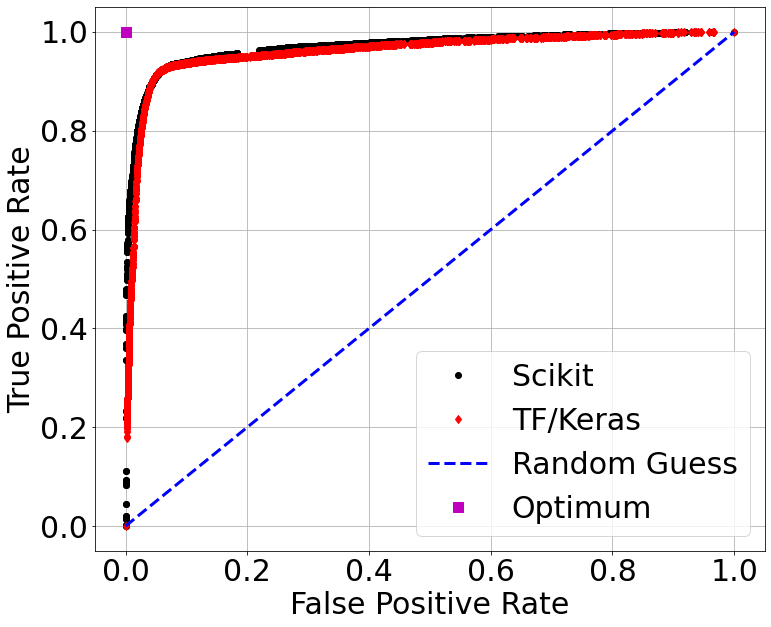

In [17]:
fpr_lep_scikit, tpr_lep_scikit, th_lep_scikit = roc_curve(data_df['label'],data_df['scikit_prob_lep'],pos_label=1)
fpr_lep_keras, tpr_lep_keras, th_lep_keras = roc_curve(data_df['label'],data_df['keras_prob_lep'],pos_label=1)

fig_roc,ax_roc = plt.subplots(figsize=(12,10))

ax_roc.plot(fpr_lep_scikit,tpr_lep_scikit,'ko',label='Scikit')
ax_roc.plot(fpr_lep_keras,tpr_lep_keras,'rd',label='TF/Keras')
ax_roc.plot([0.0,1.0],[0.0,1.0],'b--',linewidth=3.0,label='Random Guess')
ax_roc.plot([0.0],[1.0],'ms',markersize=10,label='Optimum')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()
ax_roc.grid(True)

fig_roc.savefig('ROC_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')

roc_optimum_scikit, opt_fpr_scikit, opt_tpr_scikit, opt_thresh_scikit, scanned_d_scikit = ana_utils.get_optimum_from_roc(fpr_lep_scikit, tpr_lep_scikit, th_lep_scikit)
roc_optimum_keras, opt_fpr_keras, opt_tpr_keras, opt_thresh_keras, scanned_d_keras = ana_utils.get_optimum_from_roc(fpr_lep_keras, tpr_lep_keras, th_lep_keras)

## Display ROC-optima

  
Scikit Neural Network:
---------------
Minimum d(t): 0.009388250000000008
TPR: 0.9248
FPR: 0.0611
Threshold t: 0.4732094460641198
---------------
  
TF/Keras Neural Network:
--------------
Minimum d(t): 0.009417280000000007
TPR: 0.9228
FPR: 0.0588
Threshold t: 0.46482834
--------------
  


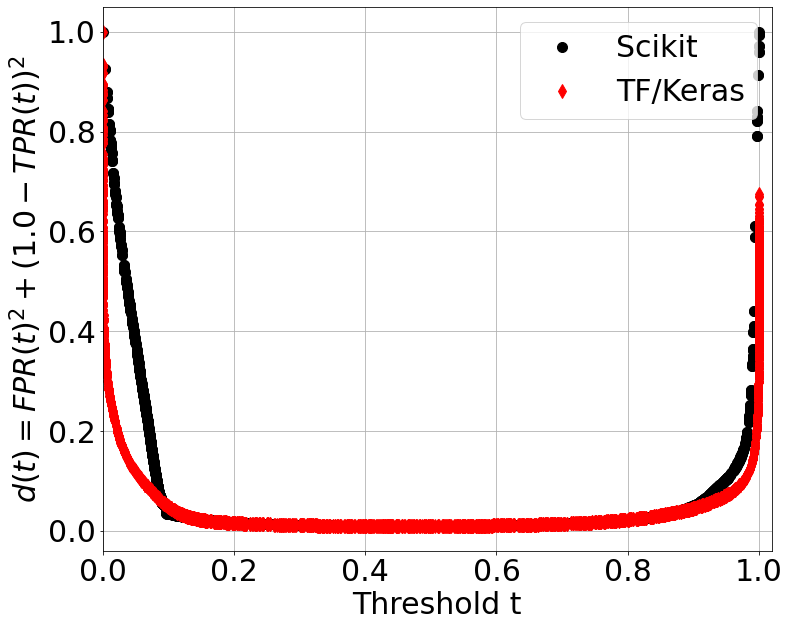

In [18]:
print("  ")
print("Scikit Neural Network:")
print("---------------")
print("Minimum d(t): " + str(roc_optimum_scikit))
print("TPR: " + str(opt_tpr_scikit))
print("FPR: " + str(opt_fpr_scikit))
print("Threshold t: " + str(opt_thresh_scikit))
print("---------------")

print("  ")
print("TF/Keras Neural Network:")
print("--------------")
print("Minimum d(t): " + str(roc_optimum_keras))
print("TPR: " + str(opt_tpr_keras))
print("FPR: " + str(opt_fpr_keras))
print("Threshold t: " + str(opt_thresh_keras))
print("--------------")
print("  ")


fig_d,ax_d = plt.subplots(figsize=(12,10))
ax_d.plot(th_lep_scikit,scanned_d_scikit,'ko',markersize=10,label='Scikit')
ax_d.plot(th_lep_keras,scanned_d_keras,'rd',markersize=10,label='TF/Keras')
ax_d.set_xlabel("Threshold t")
ax_d.set_ylabel(r'$d(t) = FPR(t)^{2} + (1.0-TPR(t))^{2}$')
ax_d.set_xlim(0.0,1.02)
ax_d.legend()
ax_d.grid(True)

fig_d.savefig('ROC_threshold_scan_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')

## Get confusion matrix for each classifier

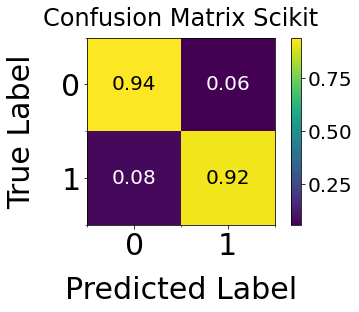

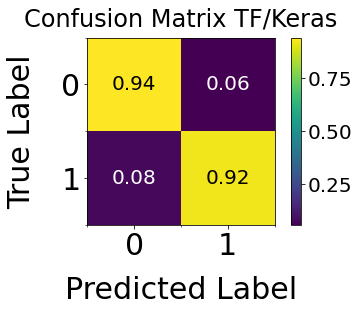

In [19]:
#First, get the keras label:
keras_labels = np.where(keras_probabilities >= opt_thresh_keras,1.0,0.0)
data_df['keras_label'] = keras_labels

fig_cm_scikit,ax_cm_scikit = ana_utils.get_confusion_matrix(data_df,'label','scikit_label',[0,1],'Confusion Matrix Scikit')
fig_cm_keras,ax_cm_keras = ana_utils.get_confusion_matrix(data_df,'label','keras_label',[0,1],'Confusion Matrix TF/Keras')

fig_cm_scikit.savefig('confusion_matrix_scikit_' + plot_dict[charge][2] + '-' + ana_add_name + '.png')
fig_cm_keras.savefig('confusion_matrix_keras_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')


## Calculate accuracy and Matthews Correlation Coefficient (MCC) for each classifier

In [20]:
accuracy_scikit = accuracy_score(data_df['label'],scikit_labels)
mcc_scikit = matthews_corrcoef(data_df['label'],scikit_labels)

accuracy_keras = accuracy_score(data_df['label'],keras_labels)
mcc_keras = matthews_corrcoef(data_df['label'],keras_labels)

print("  ")
print("Scikit Neural Network:")
print("---------------")
print("Accuracy: " + str(accuracy_scikit))
print("MCC: " + str(mcc_scikit))
print("---------------")

print("  ")
print("Keras Neural Network:")
print("--------------")
print("Accuracy: " + str(accuracy_keras))
print("MCC: " + str(mcc_keras))
print("--------------")
print("  ")

#-------------------------------------
if n_df_rows > 0:
    print("--> Show dataframe")
    print(" ")
    print(data_df.head(n_df_rows))
    print(" ")
#-------------------------------------

  
Scikit Neural Network:
---------------
Accuracy: 0.932
MCC: 0.8641833818870176
---------------
  
Keras Neural Network:
--------------
Accuracy: 0.932
MCC: 0.864146295068292
--------------
  
